## 1.- Data Loading and Initial Data Exploration

In [2]:
!nvidia-smi | grep "Tesla"

|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |


In [3]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
link = 'https://drive.google.com/open?id=1QJPpFDz3xhlT8ySfAYHuJByqdp8_C7WH'

In [5]:
fluff, id = link.split('=')
print(id) 

1QJPpFDz3xhlT8ySfAYHuJByqdp8_C7WH


In [6]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('prostateX-Register-chopedcropped-60-4channels')  
# Dataset is now stored in a Pandas Dataframe
!ls

adc.json  model.png  prostateX-Register-chopedcropped-60-4channels  sample_data


In [7]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import glob
from math import log
from bisect import bisect_left
import pickle
from google.colab import files
from tqdm import tqdm
from pathlib import Path
import tensorflow as tf
import itertools

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from keras.engine.input_layer import Input
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils
from sklearn import preprocessing
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import regularizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation
from keras import backend as K 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score as areauc

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [8]:
infile = open("prostateX-Register-chopedcropped-60-4channels",'rb')
Images = pickle.load(infile)
Labels = pickle.load(infile)
Coordinates = pickle.load(infile)
Case = pickle.load(infile)
infile.close()

In [9]:
samples = list()

for i in range (1,6):
  samples.append((i, np.where(np.array(Labels) == i)[0][0]))

f = [i[1] for i in samples]
samples, f

([(1, 1), (2, 2), (3, 0), (4, 6), (5, 11)], [1, 2, 0, 6, 11])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------Patient: 1--------- with lession grade  1


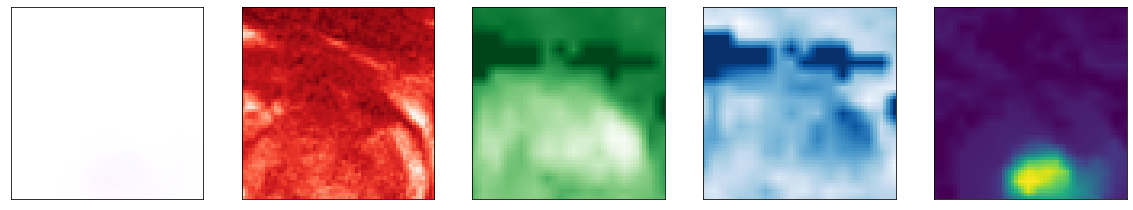

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


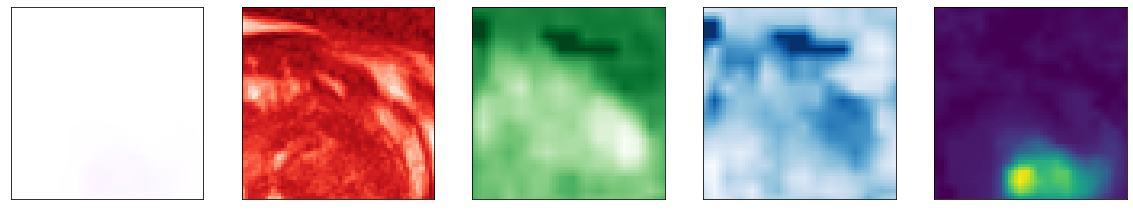

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


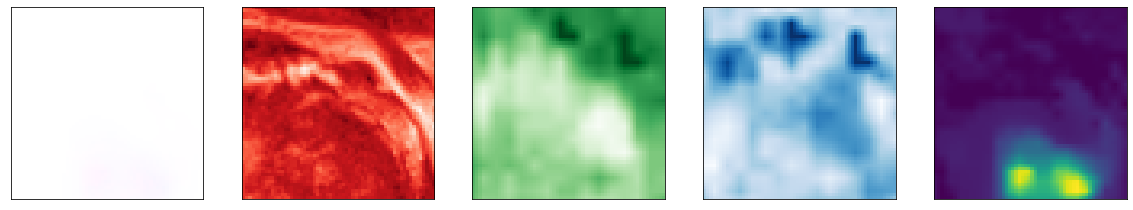

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


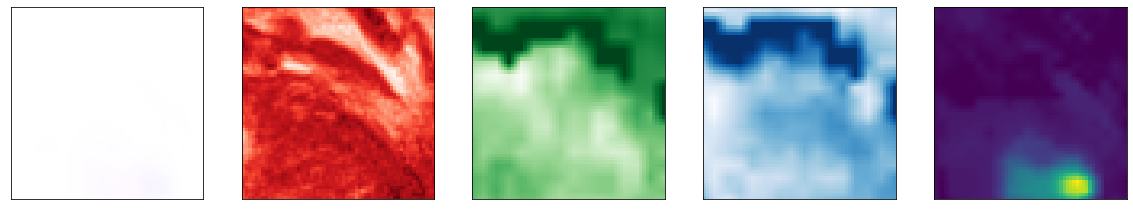

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


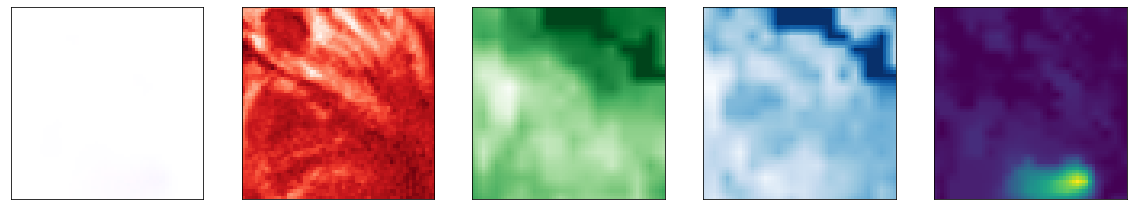

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 
------------------------------------Patient: 2--------- with lession grade  2


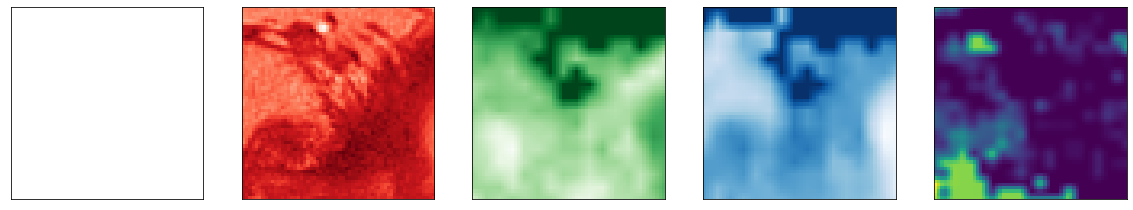

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


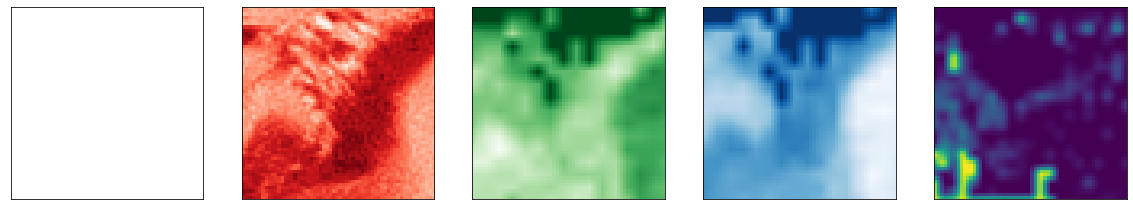

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


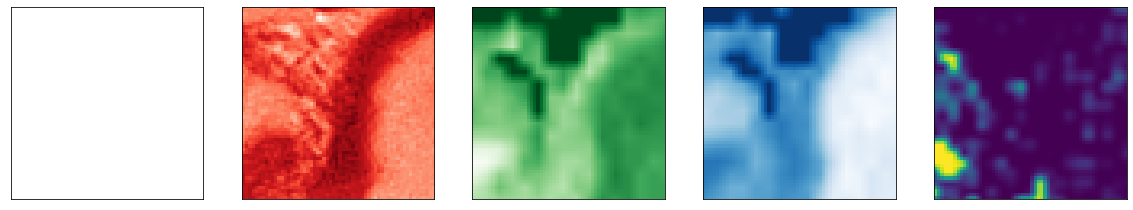

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


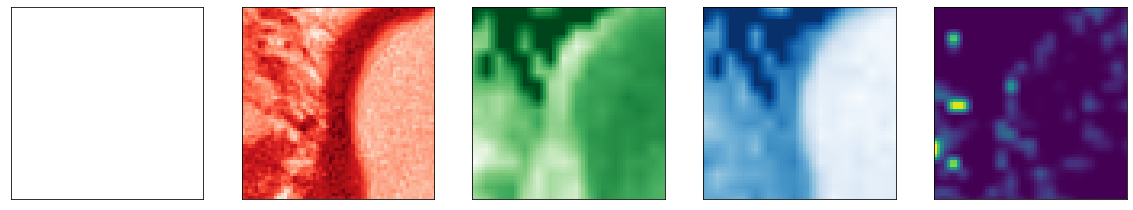

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


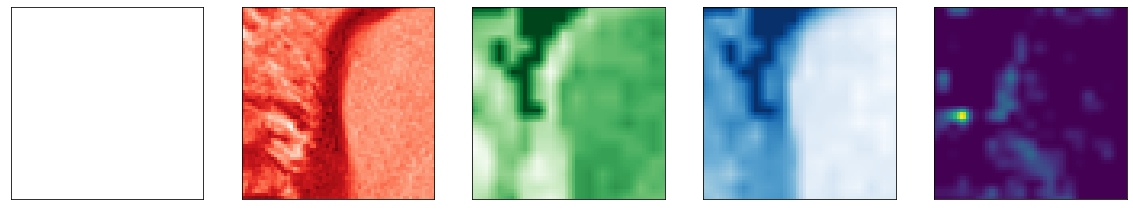

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 
------------------------------------Patient: 0--------- with lession grade  3


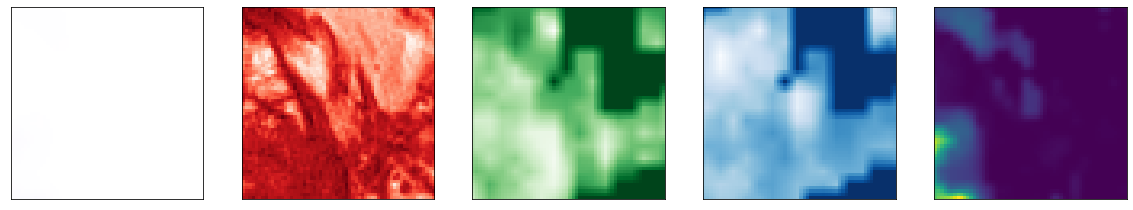

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


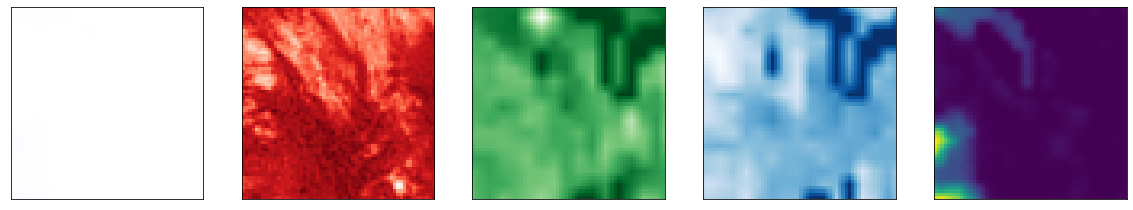

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


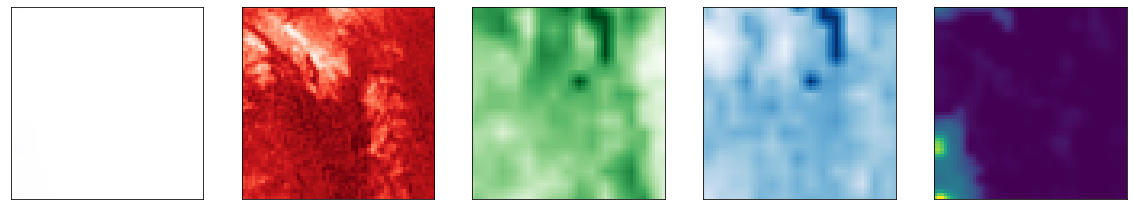

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


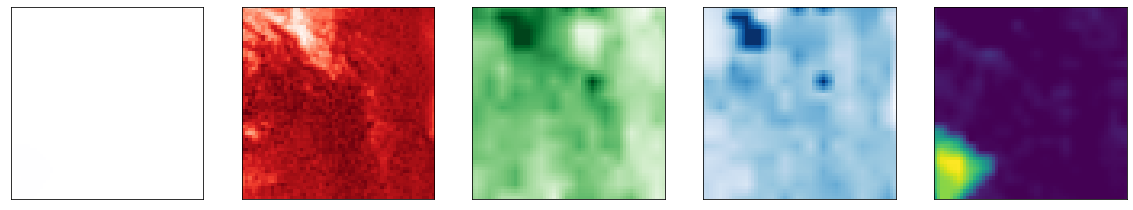

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


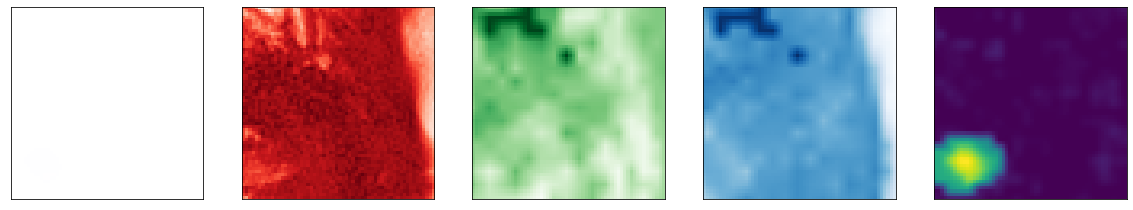

In [10]:
q = 0
for i in f[:3]:
  q += 1
  print("------------------------------------Patient: "+str(i) +"--------- with lession grade ", q)
  patient = Images[i]/255
  for j in range(patient.shape[0]):
    image = patient[j]
    label = Labels[i]
    coor = Coordinates[i]
    cmaps = [None, plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r, None]

    fig, axes = plt.subplots(1, 5, figsize=(20,10))
    objs = zip(axes, (image, *image.transpose(2,0,1)), cmaps)

    for ax, channel, cmap in objs:
      # print(channel.shape)
        ax.imshow(channel, cmap=cmap)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()
    print(" ")

In [11]:
binaryLabels = [ 0 if i ==1 else 1 for i in Labels ]
binaryLabelsreshape = np_utils.to_categorical(binaryLabels)

In [12]:

train_X = Images[34:, :, :, :, :]
print(len(train_X))
train_y = binaryLabelsreshape[34:]
print(len(train_y))

val_X = Images[:34, :, :, :, :]
print(len(val_X))
val_y = binaryLabelsreshape[:34]
print(len(val_y))

78
78
34
34


In [13]:
trainStats = np.unique(binaryLabels[:], return_counts=True)
trainStats

(array([0, 1]), array([36, 76]))

In [14]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(binaryLabels),
                                                 binaryLabels)
class_weights

array([1.55555556, 0.73684211])

Completelly unbalanced dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


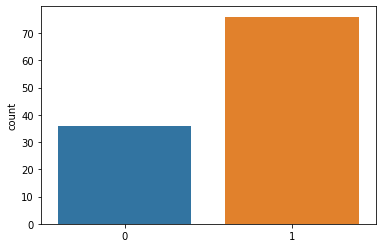

In [15]:
import seaborn as sbn
sbn.countplot(binaryLabels)

## BASE MODEL 

In [16]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Conv3D, Dense, Flatten, MaxPooling3D
from keras import backend as K

def create_base_network(inputs):
    '''Base network to be shared (eq. to feature extraction).
    '''
    x = Conv3D(4, kernel_size=(1, 3, 3), activation='relu')(inputs)
    x = Conv3D(4, (3, 3, 3), activation='relu')(x)
    x = Conv3D(8, (1, 3, 3), activation='relu')(x)
    x = Conv3D(8, (3, 3, 3), activation='relu')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = Conv3D(16, (1, 3, 3), activation='relu')(x)
    x = Conv3D(32, (1, 3, 3), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
 
    return x

In [17]:
input_shape = (5, 60, 60, 4)
input1 = Input(shape=input_shape)
mod1 = create_base_network(input1)
output = Dense(2, activation='softmax')(mod1)

model = Model(inputs=input1, outputs=[output])
model.summary()

sgd = optimizers.SGD(lr=0.000001)

model.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])


# Save the model according to the conditions  
MODEL = 'current.h5' 
checkpoint = ModelCheckpoint(MODEL, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=0.00000001, verbose = 1)

BATCH_SIZE = 1
# Train the model 
hist= model.fit(
x= [train_X], y=train_y,
epochs = 150,
batch_size=BATCH_SIZE,
validation_data = (val_X, val_y),
callbacks = [checkpoint, early, reduce_lr]
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 60, 60, 4)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 5, 58, 58, 4)      148       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 56, 56, 4)      436       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 54, 54, 8)      296       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 52, 52, 8)      1736      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 1, 26, 26, 8)      0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 1, 24, 24, 16)     1168  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
78/78 [==============================] - 18s 18ms/step - loss: 9.6236 - accuracy: 0.5298 - val_loss: 6.2616 - val_accuracy: 0.7059
Epoch 2/150
78/78 [==============================] - 1s 9ms/step - loss: 4.6565 - accuracy: 0.6483 - val_loss: 5.8159 - val_accuracy: 0.7059
Epoch 3/150
78/78 [==============================] - 1s 8ms/step - loss: 3.1542 - accuracy: 0.6311 - val_loss: 5.2606 - val_accuracy: 0.7059
Epoch 4/150
78/78 [==============================] - 1s 8ms/step - loss: 2.8239 - accuracy: 0.6378 - val_loss: 4.1027 - val_accuracy: 0.5882
Epoch 5/150
78/78 [==============================] - 1s 9ms/step - loss: 2.7393 - accuracy: 0.6132 - val_loss: 3.9025 - val_accuracy: 0.5588
Epoch 6/150
78/78 [==============================] - 1s 8ms/step - loss: 0.6522 - accuracy: 0.9050 - val_loss: 6.1301 - val_accuracy: 0.4412
Epoch 7/150
78/78 [==============================] - 1s 8ms/step - loss: 2.1778 - accuracy: 0.7145 - val_loss: 3.5743 - val_accuracy: 0.5588
Epoch 8/150

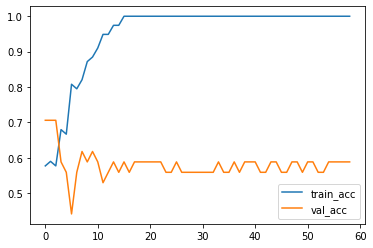

In [18]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train_acc', 'val_acc'])

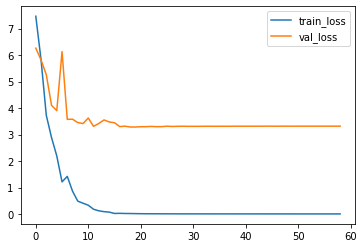

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])

In [20]:
preds = np.argmax(model.predict([val_X]), axis =-1)
truths = np.array(binaryLabels[:34])

preds, truths

(array([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]),
 array([1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]))

Confusion matrix, without normalization
[[ 2  7]
 [ 7 18]]


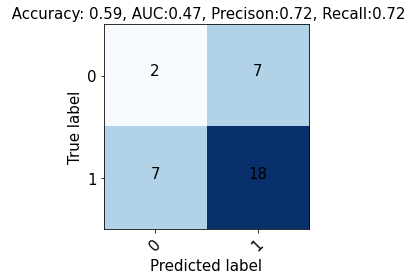

In [21]:

# define confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

#     plt.figure(figsize= (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black", fontsize=15)

    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.tight_layout()

cnf_matrix = confusion_matrix(truths, preds)
accuracy = np.around(accuracy_score(truths, preds),2)
auc = np.around(areauc(truths, preds), 2)
prec = np.around(precision_score(truths, preds, average='binary'), 2)
recall = np.around(recall_score(truths ,preds, average='binary'), 2)

plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                        title=' Accuracy: ' +str(accuracy)
                        + ', AUC:' + str(auc)
                        + ', Precison:' + str(prec)
                        + ', Recall:' + str(recall)
                     )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Paciente --> 0


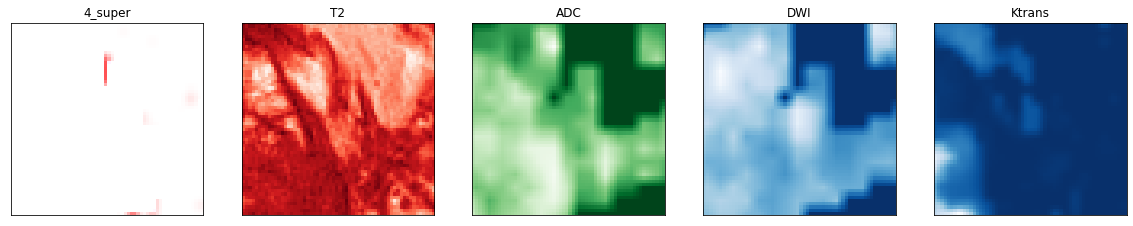

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


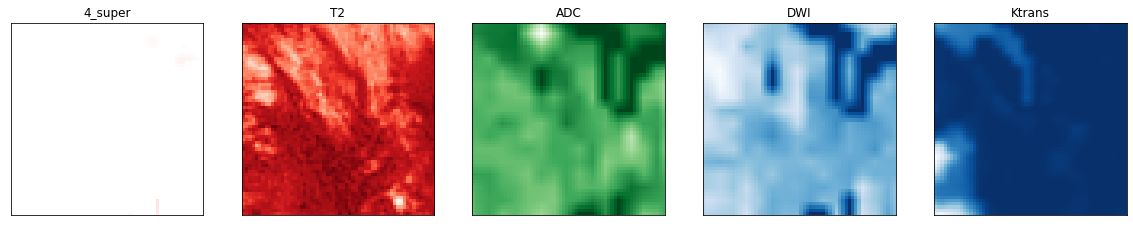

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


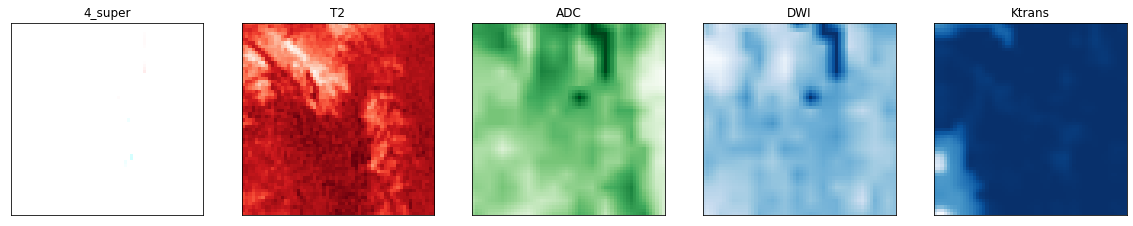

 <------  Toma Central  -------> 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


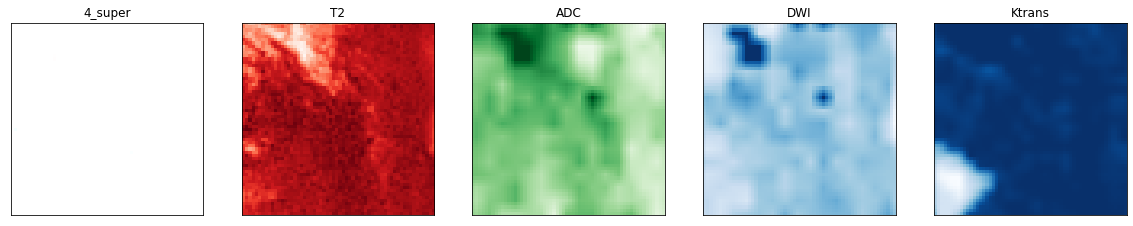

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


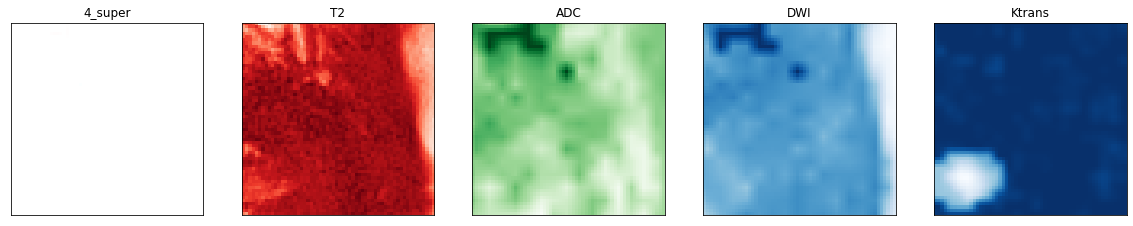

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 
 Paciente --> 1


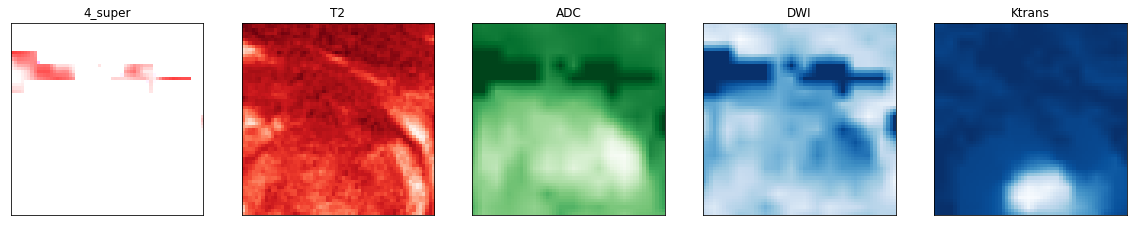

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


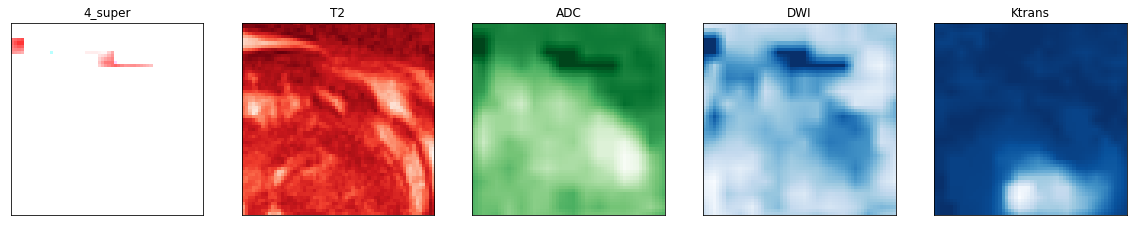

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


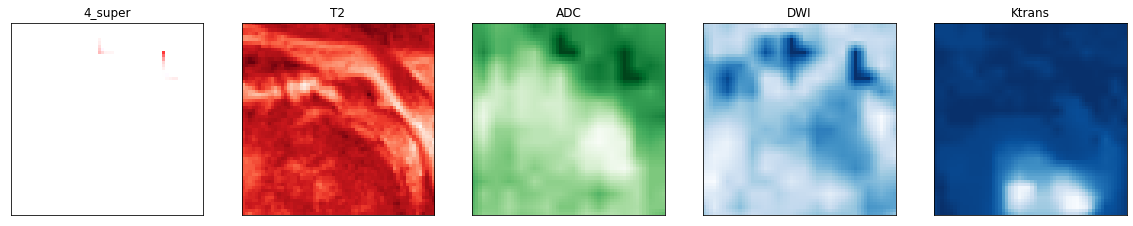

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 <------  Toma Central  -------> 


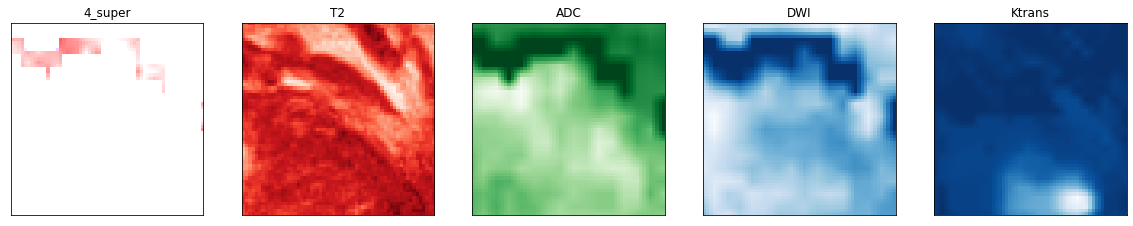

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


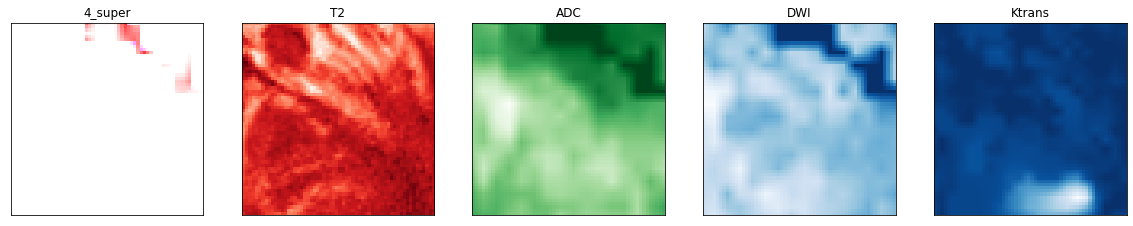

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 
 Paciente --> 2


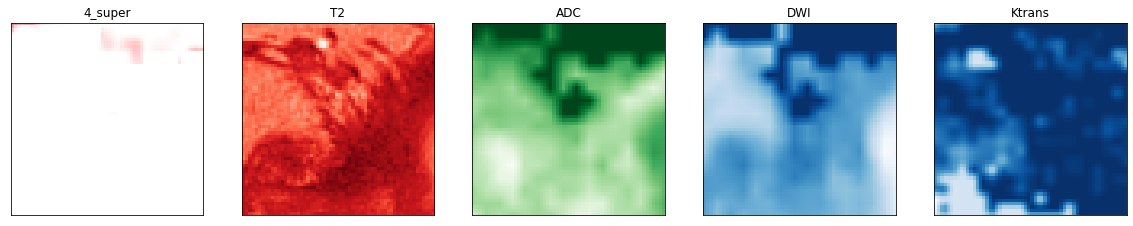

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


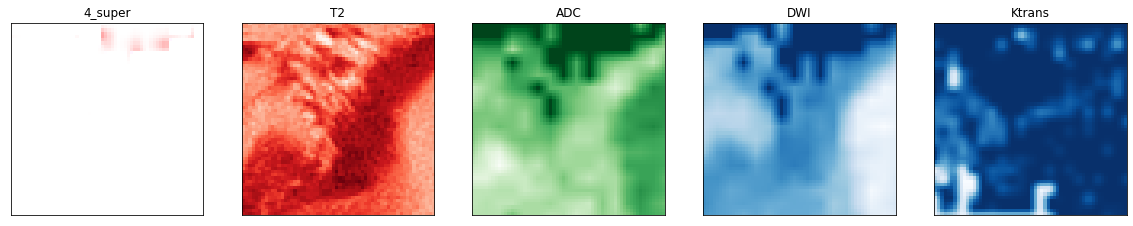

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


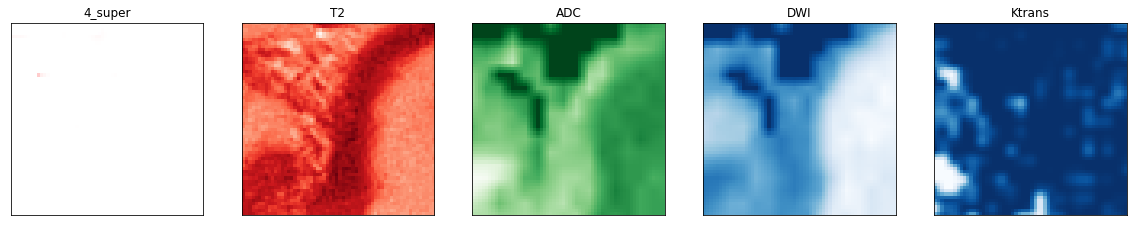

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 <------  Toma Central  -------> 


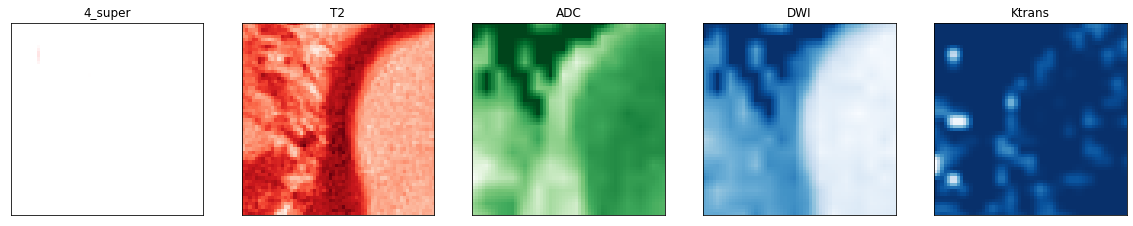

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


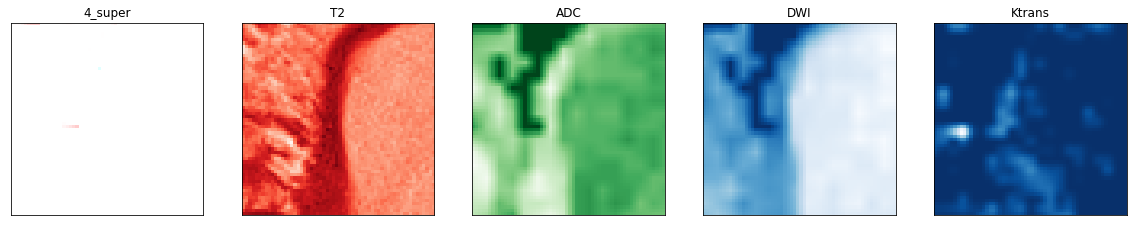

In [22]:
cmaps = [None, plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r, plt.cm.Blues_r]
t = ['4_super', 'T2', 'ADC', 'DWI', 'Ktrans']

for paciente in range(0, 3):
  print(f" Paciente --> {paciente}")
  corte = 0
  for corte in range(0,5):
    image = val_X[paciente, corte, :, :, :]
    fig, axes = plt.subplots(1, 5, figsize=(20,10))
    objs = zip(axes, (image, *image.transpose(2,0,1)), cmaps)
    q = 0
    for ax, channel, cmap in objs:     
        ax.imshow(channel, cmap=cmap)
        ax.set_title(t[q])
        ax.set_xticks(())
        ax.set_yticks(())
        q += 1
    # fig.suptitle(t[q], fontsize=16)
    plt.show()
    # print(f" Corte {t[q]}")
    if corte == 2:
      print(" <------  Toma Central  -------> ")
    corte += 1
  print(" ")
    

In [23]:
negs = val_X[np.where(truths == 0)]
preds = np.argmax(model.predict([negs]), axis =-1)
preds

array([1, 1, 0, 1, 1, 1, 1, 0, 1])

Same cut, different channels

 Paciente --> 0


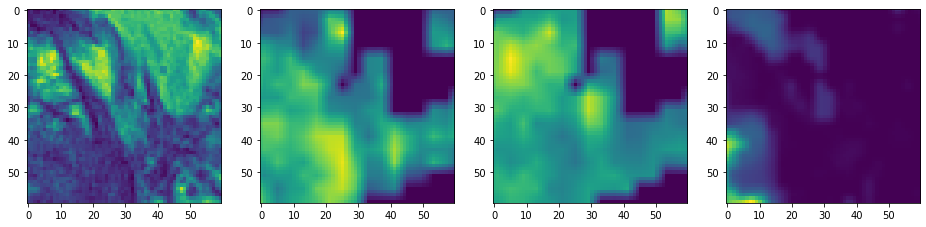

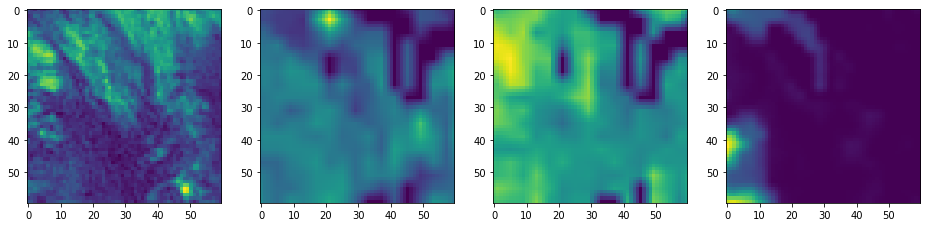

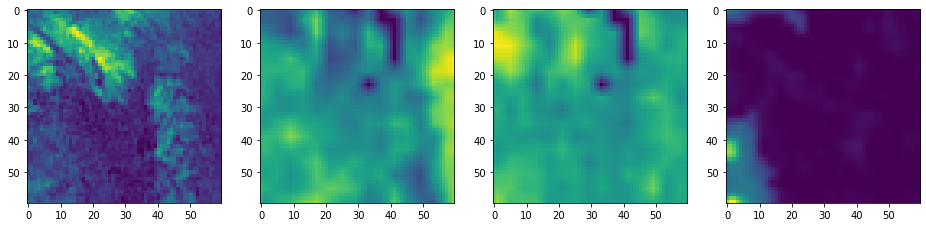

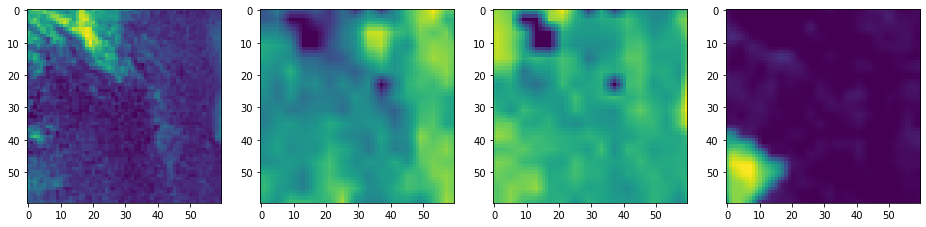

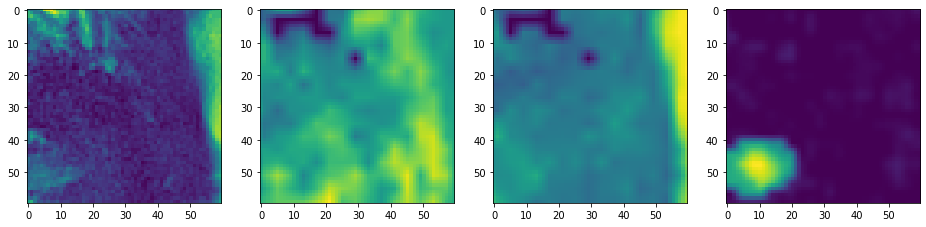

 
 Paciente --> 1


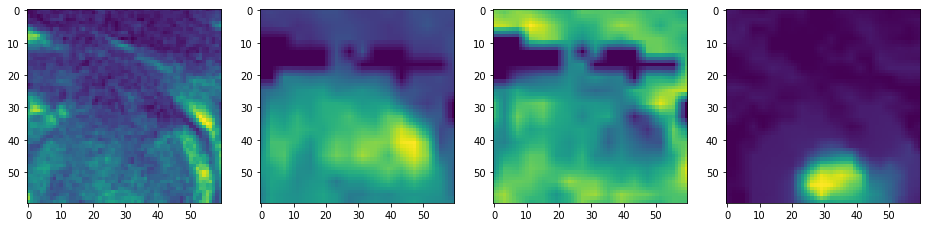

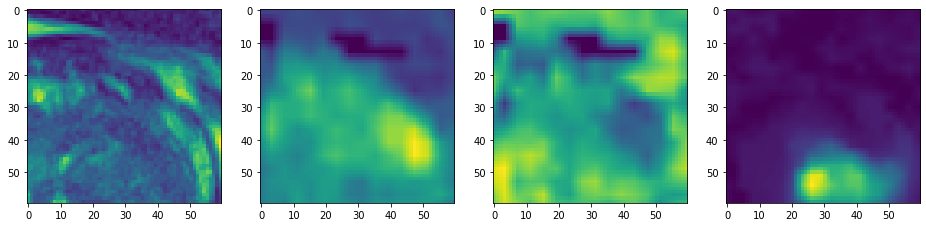

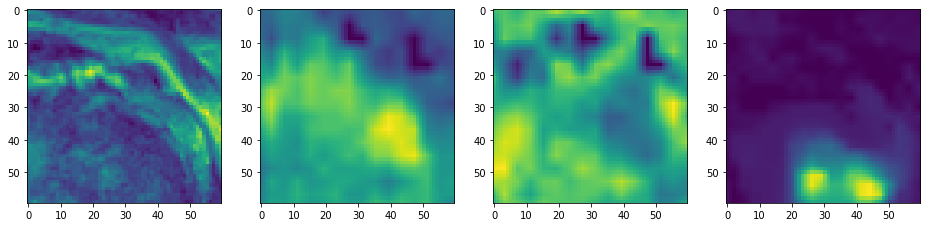

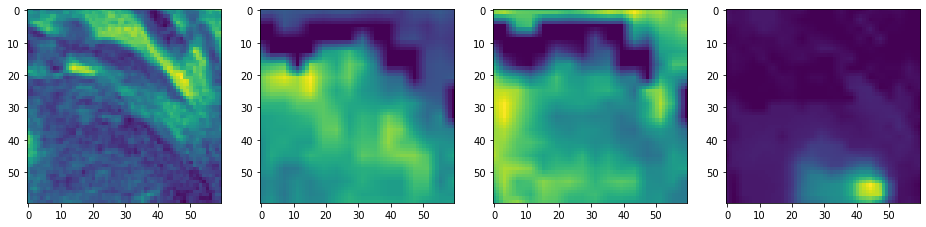

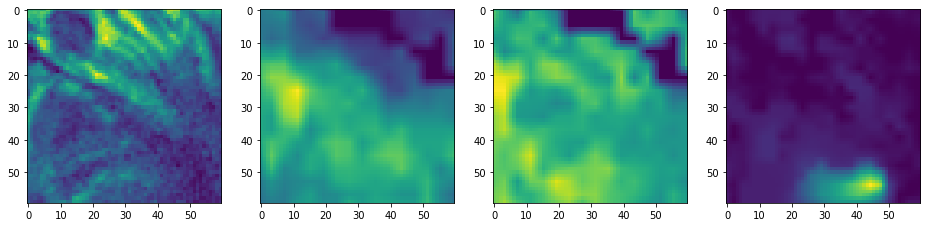

In [24]:
for paciente in range(0, 2):
  print(f" Paciente --> {paciente}")
  for i in range(0,5):
    fig, axes = plt.subplots(ncols=4, figsize=(16, 12))
    ax1, ax2, ax3, ax4 = axes
    im1 = ax1.imshow(val_X[paciente, i, :, :, 0])
    im2 = ax2.imshow(val_X[paciente, i, :, :, 1])
    im3 = ax3.imshow(val_X[paciente, i, :, :, 2])
    im4 = ax4.imshow(val_X[paciente, i, :, :, 3])
    plt.show()
  print(" ")

In [25]:
import imutils

 
rot = imutils.rotate(image, angle=355)
# plt.imshow(rot)

In [26]:
negs = np.where(np.array(binaryLabels[34:]) == 0)[0]
negs

array([ 3,  5,  9, 20, 24, 28, 30, 31, 39, 40, 42, 43, 44, 47, 48, 49, 50,
       51, 53, 54, 56, 57, 58, 59, 63, 67, 69])

# Data Augmentation


Just because we have seen the class distribution is unbalanced we will perform some data augmentation enforcing the minor category.

To do so, we will iterate over the training set and we will tilt a bit 10º left/ right the image with 50% chances for category 1 and 66% for category and same probability to rotate the image clockwise or anti-clockwise.

In [27]:
pacients = Images[34:, :, :, :, :].shape[0]
cuts = Images[34:, :, :, :, :].shape[1]
channels = Images[34:, :, :, :, :].shape[4]

Train2 = Images[34:, :, :, :, :]
print(f" Initial Train2 shape {Train2.shape}")
negs = np.where(np.array(binaryLabels[34:]) == 0)[0]
labels = binaryLabels[34:]
n_labels = list()
for pacient in range(0, pacients):
  dado = np.random.randint(0, 4)
  if pacient in negs:
    th = 0
  else:
    th = 1
  if dado > th:
    tensor = list()
    for cut in range(0, cuts):
      for channel in range(0, channels):
        imagen = Images[pacient, cut, :, :, channel]
        dado = np.random.randint(0, 4)
        if dado < 2:
          rot = imutils.rotate(imagen, angle=350)
          # fig, (ax1, ax2) = plt.subplots(1, 2)
          # ax1.imshow(imagen)
          # ax1.axis('off')
          # ax2.imshow(rot)
          # ax2.axis('off')
          # plt.show()
        else:
          rot = imutils.rotate(imagen, angle = 10)
        tensor.append(rot)
    
    Train2 = np.concatenate((Train2, np.array(tensor).reshape(1, 5, 60, 60, 4)), axis = 0)
    n_labels.append(labels[pacient])

labels += n_labels
print(f" Final train shape {Train2.shape} and labels ---> {len(labels)}")

 Initial Train2 shape (78, 5, 60, 60, 4)
 Final train shape (127, 5, 60, 60, 4) and labels ---> 127


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


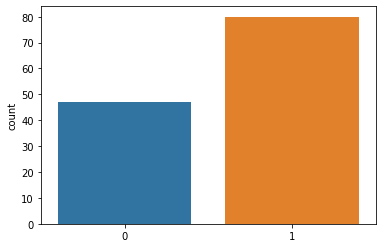

In [28]:
import seaborn as sbn
sbn.countplot(labels)

We can observe less different between number of samples by each class now. We will try again the base model and try to see if it improves the results.

In [29]:
binaryLabelsreshape_train = np_utils.to_categorical(labels)
print(f" Final train shape {Train2.shape} and labels ---> {len(binaryLabelsreshape_train)}")
# val_X = Images[:34, :, :, :, :]
# print(len(val_X))
# val_y = binaryLabelsreshape[:34]
# print(len(val_y))

 Final train shape (127, 5, 60, 60, 4) and labels ---> 127


In [30]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Conv3D, Dense, Flatten, MaxPooling3D
from keras import backend as K

def create_base_network(inputs):
    '''Base network to be shared (eq. to feature extraction).
    '''
    x = Conv3D(8, kernel_size=(1, 3, 3), activation='relu')(inputs)
    x = Conv3D(16, (3, 3, 3), activation='relu')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = Conv3D(16, (1, 3, 3), activation='relu')(x)
    x = Conv3D(32, (3, 3, 3), activation='relu')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = Conv3D(32, (1, 3, 3), activation='relu')(x)
    x = Conv3D(64, (1, 3, 3), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
 
    return x

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 60, 60, 4)]    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 5, 58, 58, 8)      296       
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 3, 56, 56, 16)     3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 28, 28, 16)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 3, 26, 26, 16)     2320      
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 1, 24, 24, 32)     13856     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 12, 12, 32)     0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


127/127 [==============================] - 3s 11ms/step - loss: 447.9264 - accuracy: 0.4839 - val_loss: 0.5805 - val_accuracy: 0.6471
Epoch 2/150
127/127 [==============================] - 1s 8ms/step - loss: 0.6816 - accuracy: 0.5940 - val_loss: 0.5878 - val_accuracy: 0.7353
Epoch 3/150
127/127 [==============================] - 1s 8ms/step - loss: 0.7147 - accuracy: 0.5258 - val_loss: 0.5791 - val_accuracy: 0.7353
Epoch 4/150
127/127 [==============================] - 1s 8ms/step - loss: 0.6500 - accuracy: 0.6578 - val_loss: 0.5865 - val_accuracy: 0.7353
Epoch 5/150
127/127 [==============================] - 1s 8ms/step - loss: 0.6698 - accuracy: 0.6268 - val_loss: 0.5794 - val_accuracy: 0.7353
Epoch 6/150
127/127 [==============================] - 1s 8ms/step - loss: 0.6572 - accuracy: 0.6340 - val_loss: 0.5818 - val_accuracy: 0.7353
Epoch 7/150
127/127 [==============================] - 1s 8ms/step - loss: 0.6147 - accuracy: 0.6975 - val_loss: 0.5706 - val_accuracy: 0.7353
Epoch 8/

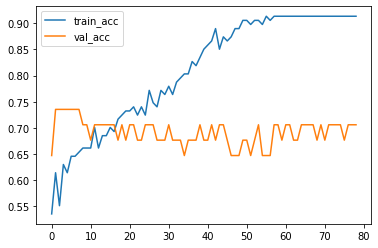

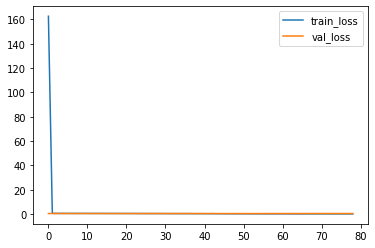

In [31]:
input_shape = (5, 60, 60, 4)
input1 = Input(shape=input_shape)
mod1 = create_base_network(input1)

output = Dense(2, activation='softmax')(mod1)

model = Model(inputs=[input1], outputs=[output])
model.summary()

sgd = optimizers.SGD(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])


# Save the model according to the conditions  
MODEL = 'current.h5' 
checkpoint = ModelCheckpoint(MODEL, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=0.000001, verbose = 1)

BATCH_SIZE = 1
# Train the model 
hist= model.fit(
x= [Train2], y=binaryLabelsreshape_train,
epochs = 150,
batch_size=BATCH_SIZE,
validation_data = (val_X, val_y),
callbacks = [checkpoint, early, reduce_lr]
)

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()



# DEEPER MODELS
VGG LIKE

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
127/127 [==============================] - 4s 17ms/step - loss: 0.7014 - accuracy: 0.2934 - val_loss: 0.6944 - val_accuracy: 0.2941
Epoch 2/200
127/127 [==============================] - 1s 11ms/step - loss: 0.6960 - accuracy: 0.3952 - val_loss: 0.6926 - val_accuracy: 0.6765
Epoch 3/200
127/127 [==============================] - 2s 13ms/step - loss: 0.6967 - accuracy: 0.3927 - val_loss: 0.6908 - val_accuracy: 0.7353
Epoch 4/200
127/127 [==============================] - 1s 11ms/step - loss: 0.6919 - accuracy: 0.4419 - val_loss: 0.6891 - val_accuracy: 0.7353
Epoch 5/200
127/127 [==============================] - 2s 13ms/step - loss: 0.6910 - accuracy: 0.5917 - val_loss: 0.6873 - val_accuracy: 0.7353
Epoch 6/200
127/127 [==============================] - 1s 11ms/step - loss: 0.6919 - accuracy: 0.5564 - val_loss: 0.6858 - val_accuracy: 0.7353
Epoch 7/200
127/127 [==============================] - 1s 12ms/step - loss: 0.6880 - accuracy: 0.6510 - val_loss: 0.6843 - val_accuracy:

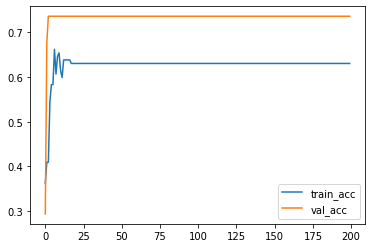

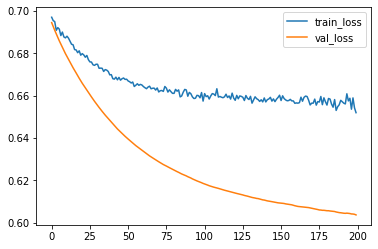

In [65]:
def create_conv_blocks(inputs, blocks: int):
    '''Base network to be shared (eq. to feature extraction).
    '''
    x = Conv3D(4, kernel_size=(3, 3, 3), activation='relu',padding='same')(inputs)
    for i in range(0,blocks):
        x = Conv3D(4*2**i, (3, 3, 3), activation='relu',padding='same')(x)
        x = Conv3D(4*2**i, (3, 3, 3), activation='relu',padding='same')(x)
        x = Conv3D(4*2**i, (3, 3, 3), activation='relu',padding='same')(x)
        x = MaxPooling3D(pool_size=(3, 3, 3), padding = 'same')(x)
        x = Dropout(0.15)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    return x

input_shape = (5, 60, 60, 4)
input1 = Input(shape=input_shape)
mod1 = create_conv_blocks(input1, 4)
x = keras.layers.concatenate([mod1])
# output = Dense(1, activation='sigmoid')(mod1)
output = Dense(2, activation='softmax')(mod1)

model_4_blocks = Model(inputs=[input1], outputs=[output])
# model.summary()
# tf.keras.utils.plot_model(
#     model,
#     show_shapes=True
# )
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
sgd = optimizers.SGD(lr=0.0001)

model_4_blocks.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=0.000001, verbose = 1)

BATCH_SIZE = 1
# Train the model 
hist= model_4_blocks.fit(
x= Train2, y=binaryLabelsreshape_train,
epochs = 200,
batch_size=BATCH_SIZE,
validation_data = (val_X, val_y),
callbacks = [early, reduce_lr], verbose = 1
)

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 5, 60, 60, 4)]    0         
_________________________________________________________________
conv3d_135 (Conv3D)          (None, 5, 60, 60, 4)      436       
_________________________________________________________________
conv3d_136 (Conv3D)          (None, 5, 60, 60, 4)      436       
_________________________________________________________________
conv3d_137 (Conv3D)          (None, 5, 60, 60, 4)      436       
_________________________________________________________________
conv3d_138 (Conv3D)          (None, 5, 60, 60, 4)      436       
_________________________________________________________________
max_pooling3d_42 (MaxPooling (None, 2, 20, 20, 4)      0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 2, 20, 20, 4)      0  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
127/127 [==============================] - 5s 20ms/step - loss: 0.6930 - accuracy: 0.5343 - val_loss: 0.6917 - val_accuracy: 0.7353
Epoch 2/200
127/127 [==============================] - 2s 13ms/step - loss: 0.6918 - accuracy: 0.6808 - val_loss: 0.6902 - val_accuracy: 0.7353
Epoch 3/200
127/127 [==============================] - 2s 14ms/step - loss: 0.6913 - accuracy: 0.6312 - val_loss: 0.6886 - val_accuracy: 0.7353
Epoch 4/200
127/127 [==============================] - 2s 13ms/step - loss: 0.6883 - accuracy: 0.7280 - val_loss: 0.6870 - val_accuracy: 0.7353
Epoch 5/200
127/127 [==============================] - 2s 13ms/step - loss: 0.6898 - accuracy: 0.6211 - val_loss: 0.6853 - val_accuracy: 0.7353
Epoch 6/200
127/127 [==============================] - 2s 13ms/step - loss: 0.6869 - accuracy: 0.6814 - val_loss: 0.6838 - val_accuracy: 0.7353
Epoch 7/200
127/127 [==============================] - 2s 13ms/step - loss: 0.6863 - accuracy: 0.6665 - val_loss: 0.6823 - val_accuracy:

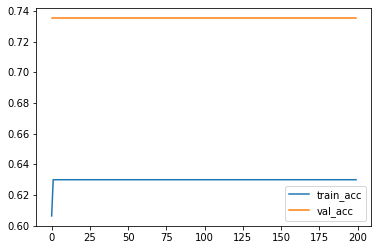

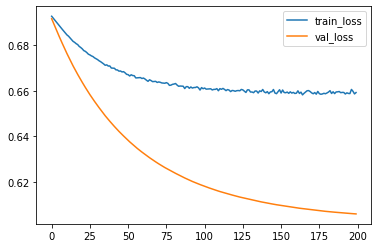

In [53]:

input_shape = (5, 60, 60, 4)
input1 = Input(shape=input_shape)
mod1 = create_conv_blocks(input1, 5)
x = keras.layers.concatenate([mod1])
# output = Dense(1, activation='sigmoid')(mod1)
output = Dense(2, activation='softmax')(mod1)

model = Model(inputs=[input1], outputs=[output])
model.summary()
tf.keras.utils.plot_model(
    model,
    show_shapes=True
)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
sgd = optimizers.SGD(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=0.000001, verbose = 1)

BATCH_SIZE = 1
# Train the model 
hist= model.fit(
x= Train2, y=binaryLabelsreshape_train,
epochs = 200,
batch_size=BATCH_SIZE,
validation_data = (val_X, val_y),
callbacks = [early, reduce_lr], verbose = 1
)

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()

We can see big improvements with dropout and data agumentation

In [37]:
print("ResNET")

ResNET


In [38]:
Train2.shape, binaryLabelsreshape_train.shape

((127, 5, 60, 60, 4), (127, 2))

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 5, 60, 60, 4 0                                            
__________________________________________________________________________________________________
conv3d_179 (Conv3D)             (None, 5, 60, 60, 4) 436         input_28[0][0]                   
__________________________________________________________________________________________________
conv3d_180 (Conv3D)             (None, 5, 60, 60, 4) 436         conv3d_179[0][0]                 
__________________________________________________________________________________________________
conv3d_181 (Conv3D)             (None, 5, 60, 60, 8) 872         conv3d_180[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
127/127 [==============================] - 4s 16ms/step - loss: 69.3110 - accuracy: 0.5379 - val_loss: 0.6947 - val_accuracy: 0.6765
Epoch 2/150
127/127 [==============================] - 1s 10ms/step - loss: 0.6846 - accuracy: 0.6713 - val_loss: 0.6938 - val_accuracy: 0.6765
Epoch 3/150
127/127 [==============================] - 1s 10ms/step - loss: 0.6534 - accuracy: 0.6775 - val_loss: 0.6929 - val_accuracy: 0.6765
Epoch 4/150
127/127 [==============================] - 1s 10ms/step - loss: 0.6676 - accuracy: 0.6190 - val_loss: 0.6921 - val_accuracy: 0.6765
Epoch 5/150
127/127 [==============================] - 1s 10ms/step - loss: 0.6570 - accuracy: 0.6923 - val_loss: 0.6913 - val_accuracy: 0.6765
Epoch 6/150
127/127 [==============================] - 1s 9ms/step - loss: 0.6332 - accuracy: 0.7085 - val_loss: 0.6902 - val_accuracy: 0.6765
Epoch 7/150
127/127 [==============================] - 1s 9ms/step - loss: 0.6241 - accuracy: 0.7414 - val_loss: 0.6893 - val_accuracy: 

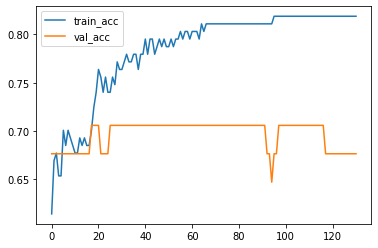


Epoch 00131: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 00131: early stopping


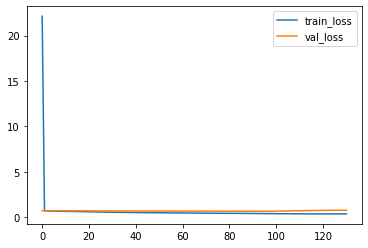

In [63]:
def create_RESNET_network(inputs):
    '''Base network to be shared (eq. to feature extraction).
    '''
    x = Conv3D(4, kernel_size=(3, 3, 3), activation='relu',padding='same')(inputs)
    x = Conv3D(4, (3, 3, 3), activation='relu',padding='same')(x)
    x = Conv3D(8, (3, 3, 3), activation='relu',padding='same')(x)
    first_block = MaxPooling3D(pool_size=(3, 3, 3), padding = 'same')(x)
    flatten1 = Flatten()(first_block)
    x = Dropout(0.15)(first_block)
    x = Conv3D(8, (3, 3, 3), activation='relu',padding='same')(x)  
    x = Conv3D(16, (3, 3, 3), activation='relu',padding='same')(x)
    x = Conv3D(16, (3, 3, 3), activation='relu', padding = 'same')(x)
    second_block = MaxPooling3D(pool_size=(3, 3, 3), padding = 'same')(x)
    flatten2 = Flatten()(second_block)
    x = Dropout(0.15)(second_block)
    x = Conv3D(32, (3, 3, 3), activation='relu',padding='same')(x)
    x = Conv3D(64, (3, 3, 3), activation='relu', padding = 'same')(x)
    x = Conv3D(64, (3, 3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling3D(pool_size=(3, 3, 3), padding = 'same')(x)
    x = Dropout(0.15)(x)
    flatten3 = Flatten()(x)
    merge = concatenate([flatten1, flatten2, flatten3])
    x_out = Dense(64, activation='relu')(merge)
    return x_out

input_shape = (5, 60, 60, 4)
input1 = Input(shape=input_shape)
mod1 = create_RESNET_network(input1)
output = Dense(2, activation='softmax')(mod1)

model = Model(inputs=[input1], outputs=[output])
model.summary()

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
sgd = optimizers.SGD(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=0.000001, verbose = 1)

BATCH_SIZE = 1
# Train the model 
hist= model.fit(
x= Train2, y=binaryLabelsreshape_train,
epochs = 150,
batch_size=BATCH_SIZE,
validation_data = (val_X, val_y),
callbacks = [early, reduce_lr], verbose = 1
)

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()

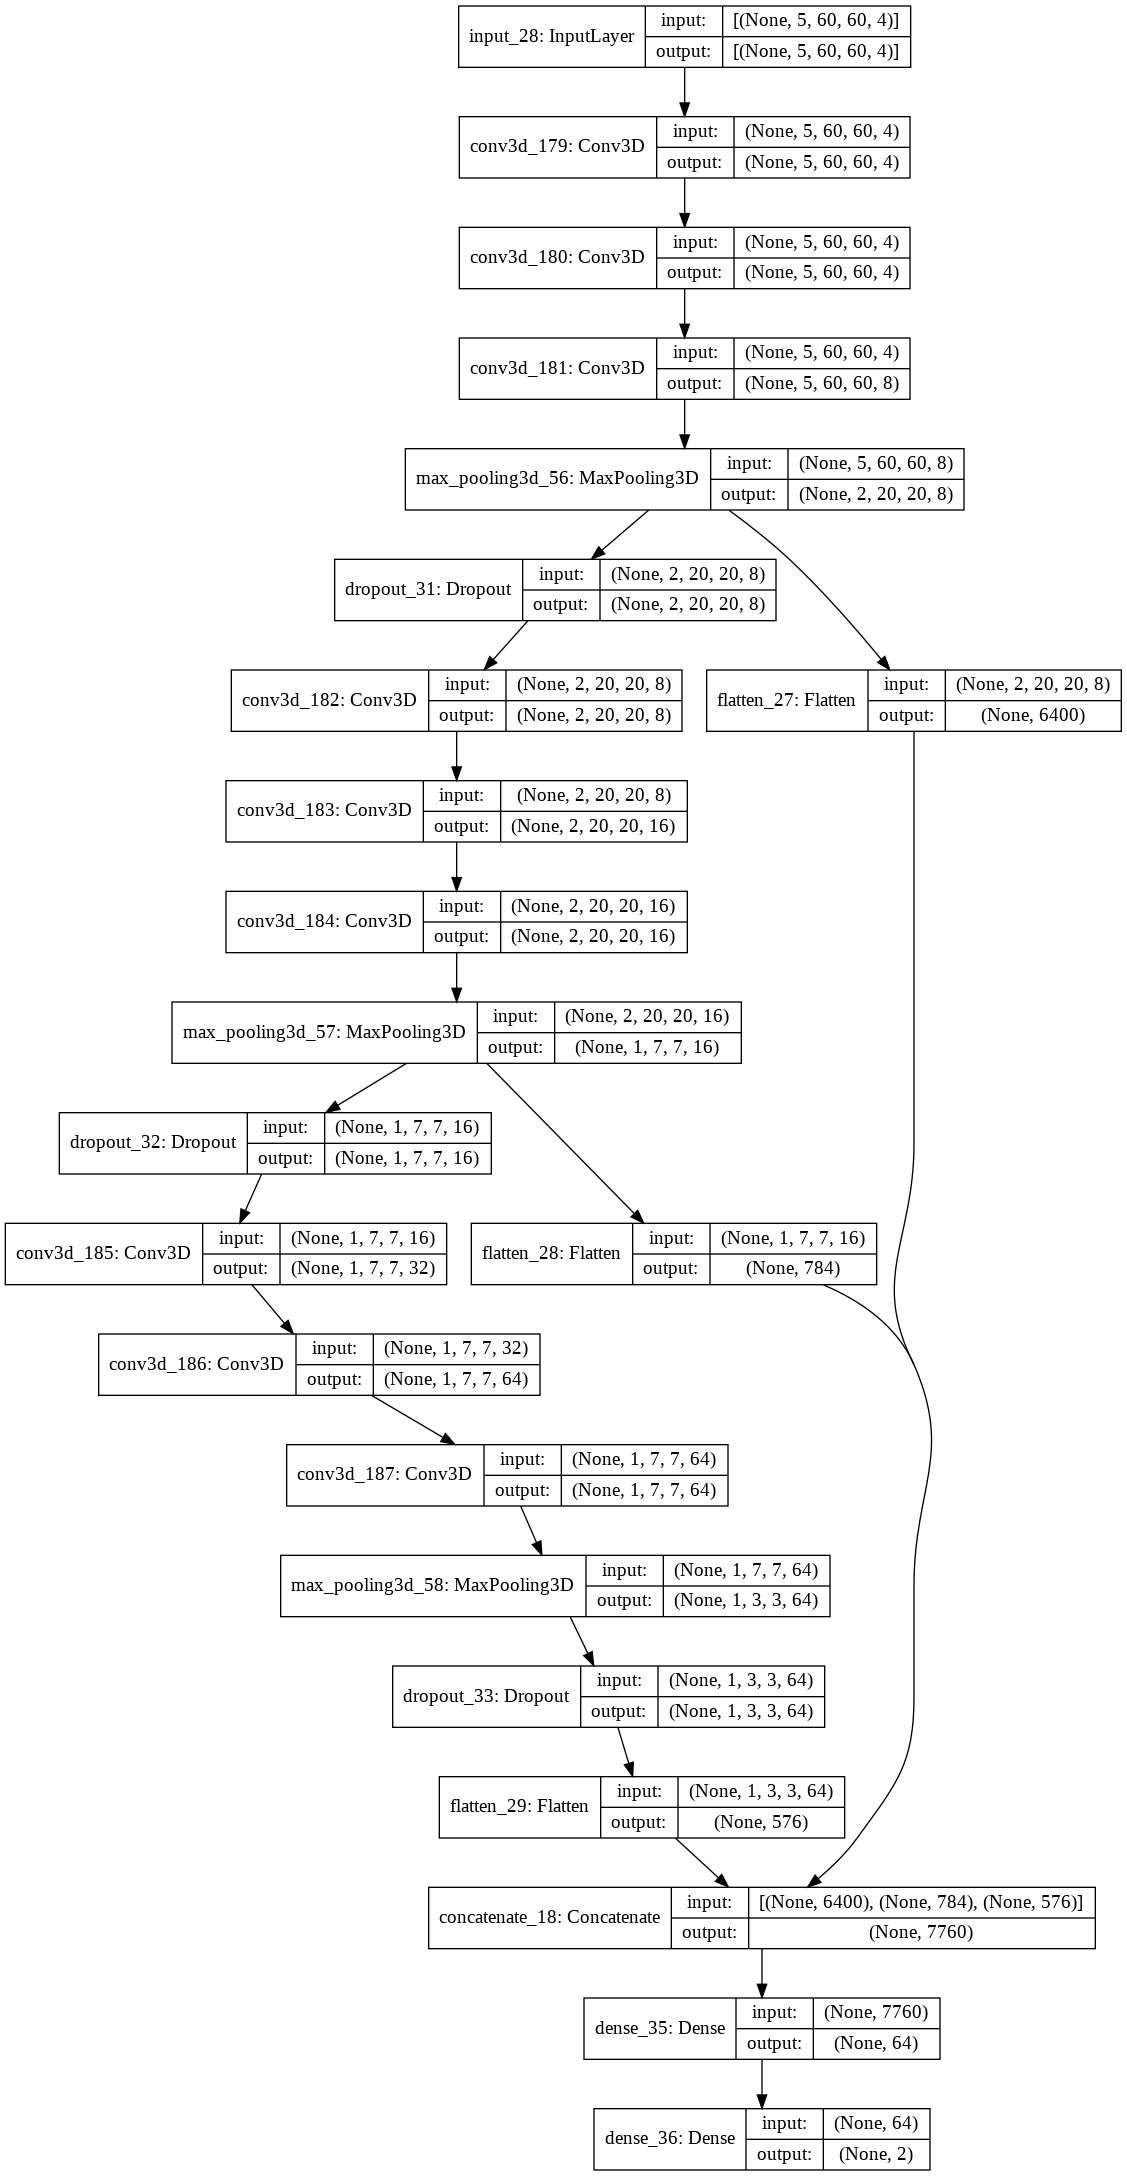

In [64]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True
)

## MonteCarlo Dropout


In [72]:
def predict_proba(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.stack(preds).mean(axis=0)
     
def predict_class(X, model, num_samples):
    proba_preds = predict_proba(X, model, num_samples)
    return np.argmax(proba_preds, axis=1)

y_pred = predict_class(val_X, model_4_blocks, 100)
acc = np.mean(y_pred == binaryLabels[:34])
acc

0.7352941176470589

In [70]:
model_4_blocks.save('model_4_blocks.h5')

new_model = keras.models.load_model('model_4_blocks.h5')
# new_model.summary()

In [81]:
np.argmax(new_model.predict(val_X[15].reshape(1, 5, 60, 60, 4)))

1